## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply region mask to ocver the lane region to focus on.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## camera calibration using chessboard images

Perform camera calibration. 

* Use real world points as coordinates of corners and compute image coordinates using opencv functions
* With this information compute distortion coefficients and camera matrix.
* Original and undistorted images are shown below. Observe that, the curved lines in original image are due to distortion and are corrected in image on right.



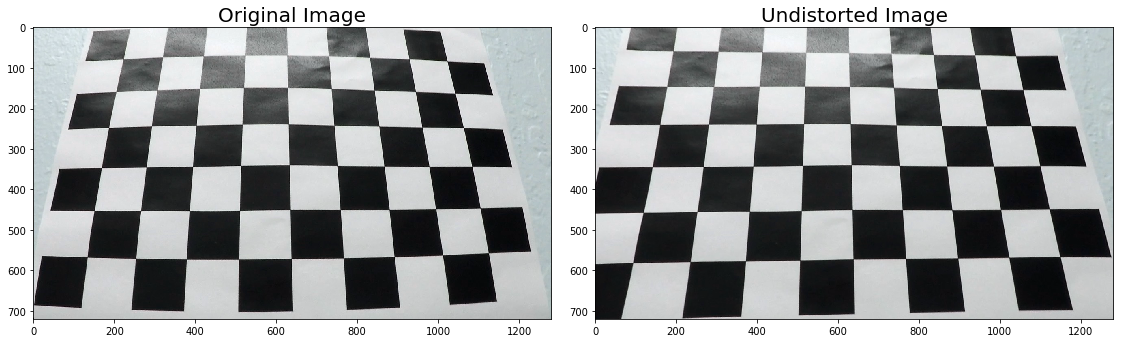

In [29]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print (corners)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)
image_raw = cv2.imread('../camera_cal/calibration3.jpg')
image = cv2.undistort(image_raw, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
f.tight_layout()
ax1.imshow(image_raw)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Sample distortion corrected image

* we pick a sample test image and undistort it using camera matrix and distortion coefficients computed in camera calibration section.

* undistorted image is denoted as **image_undistort**.

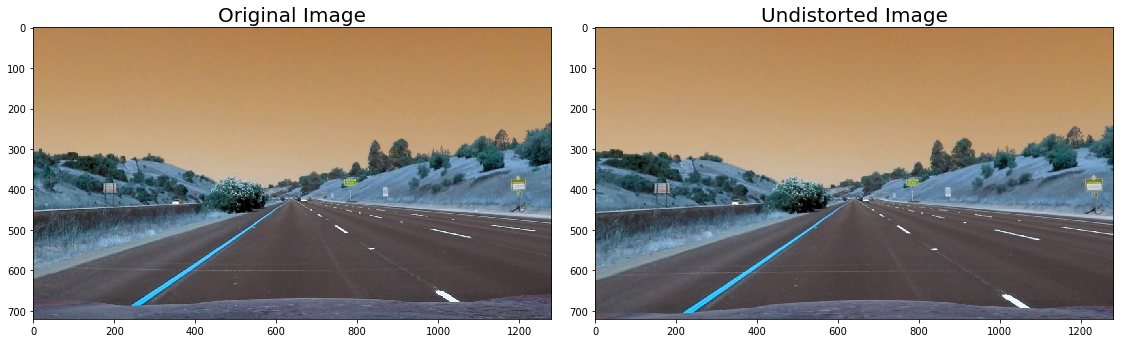

In [30]:
# Undistort a test image using above computed distortion coefficients and camera martix.

#Test image
image_raw = cv2.imread('../test_images/straight_lines1.jpg')

#openCV function to undistort camera image.
image_undistort = cv2.undistort(image_raw, mtx, dist, None, mtx)

#Plotting original and undistorted images.
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))
f.tight_layout()
ax1.imshow(image_raw)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image_undistort)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Masking of undistorted image

* In this part of code, I defined a portion of the mimage that could most likely contain all the lane information needed. 

* This masked output is saved as **image** in below code. Further processing of lane detection is performed on this processed image.

Text(0.5,1,'Masked Image')

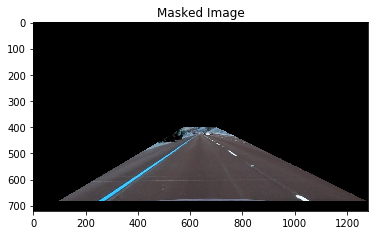

In [31]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



vertices = np.array([[(100,680),(575, 400), (700, 400), (1270,680)]], dtype=np.int32)
image = region_of_interest(image_undistort, vertices)
plt.imshow(image, cmap='gray') 
plt.title("Masked Image")
#print(combined.shape[0])



## Applying colour and gradient threasholds to obtain lane images

* Below we define few functions to compute gradients and colour thresholds. 

* Following different properties of image have be used to obtain lane information.
    * Gradient in x-direction
    * Magnitude of gradient
    * S-channel 
    * H-channel
    
* One of the major problem is the additional unncessary gradient information generated by region masking. I removed these points in the final image by masking the processed imaged with a finer region comprising of a polygon that is a subset of original mask but doesnot result in lane information loss. 
    

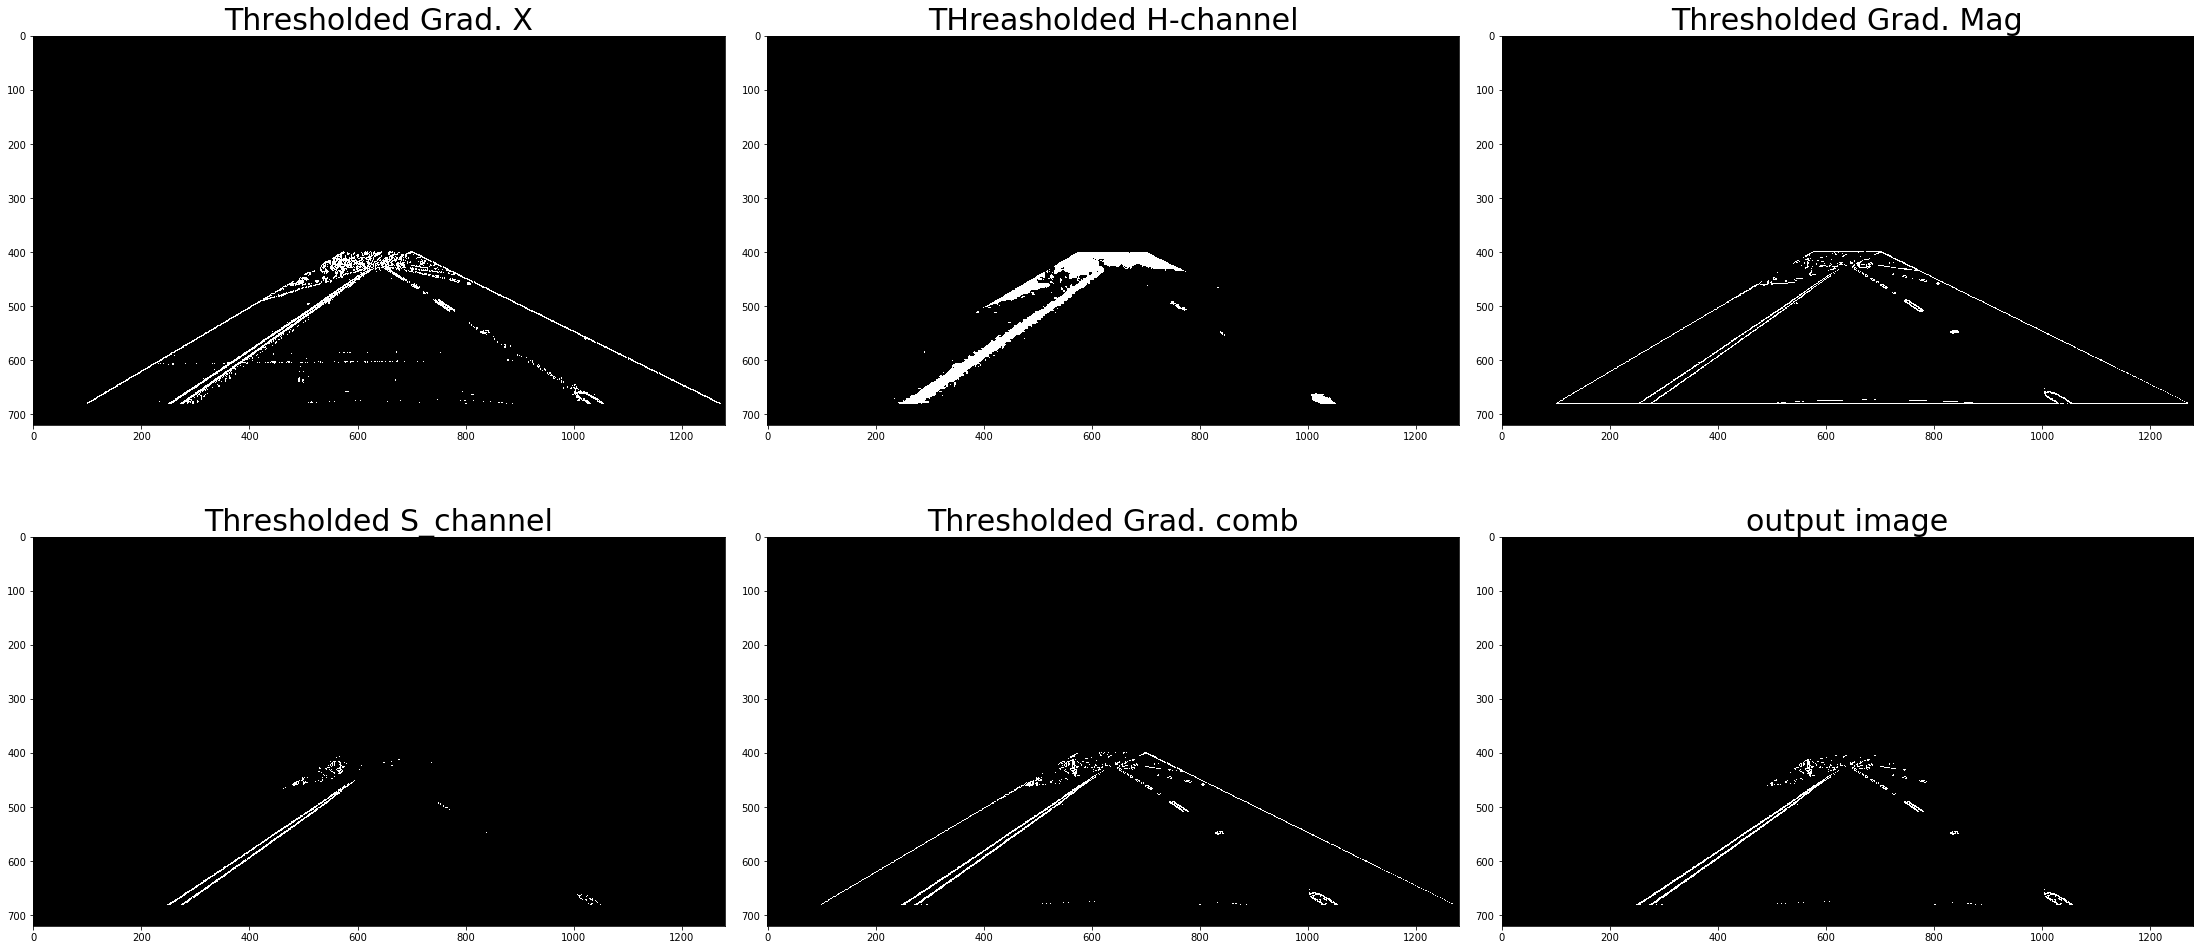

In [32]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(100, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(100, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return mag_binary


#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(10, 150))
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 250))


hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]
# Threshold color channel
s_thresh_min = 90
s_thresh_max = 200
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

h_channel = hls[:,:,0]
thresh = (10, 100)
binary = np.zeros_like(h_channel)
binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1


#Among all 
combined = np.zeros_like(s_binary)
combined[((gradx == 1) & (mag_binary == 1)) | ((s_binary == 1) & (binary == 1))] = 1 
#combined[((mag_binary == 1)) | ((s_binary == 1) & (binary == 1))] = 1 


#Additional masking to remove the edges introduced due to initial masking. 
vertices = np.array([[(120,700),(575, 405), (700, 405), (1220,700)]], dtype=np.int32)
image_new = region_of_interest(combined, vertices)
    
#combined = Combined_image(image, ksize)

f,((ax2,ax3,ax4),(ax5,ax6,ax7)) = plt.subplots(2,3, figsize=(30, 15))
f.tight_layout()
#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Thresholded Grad. X', fontsize=30)
ax3.imshow(binary, cmap='gray')
ax3.set_title('THreasholded H-channel', fontsize=30)
ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Thresholded Grad. Mag', fontsize=30)
ax5.imshow(s_binary, cmap='gray')
ax5.set_title('Thresholded S_channel', fontsize=30)
ax6.imshow(combined, cmap='gray')
ax6.set_title('Thresholded Grad. comb', fontsize=30)
ax7.imshow(image_new, cmap='gray')
ax7.set_title('output image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Masking the region of lane lines

## Applying perspective transformation to compute radius of curvature

* In this section, I performed a careful search for source and destination point to get a good warped image for straight lanes and used it for all images.

Text(0.5,1,'Warped image')

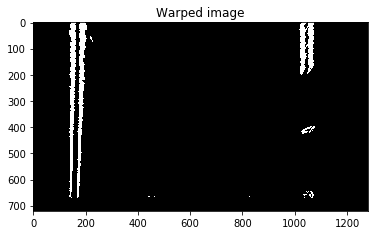

In [33]:


src = np.float32(
        [[535,490],
         [760,490],
         [200,720],
         [1150,720]])
dst = np.float32(
        [[150,0],
         [1100,0],
         [150,700],
         [1100,700]])


# M denotes the transform matrix
M = cv2.getPerspectiveTransform(src, dst)

#Minv denotes inverse transform matirx to convert back to real world corrdinates later
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (combined.shape[1], combined.shape[0])
warped = cv2.warpPerspective(image_new, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray') 
plt.title("Warped image")

## Detecting lane pixels and fitting a polynomial for lane markings

360.0


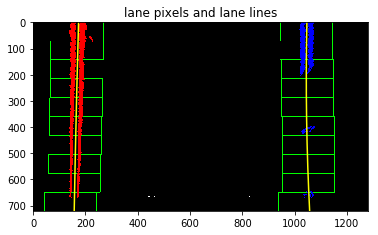

In [36]:

def polyfit(warped, plot_lanes):
    binary_warped = np.copy(warped)
    print(binary_warped.shape[0]/2)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #print(right_lane_inds.shape[0])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    if plot_lanes == True:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #out_img = np.dstack((warped, warped, warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.title("lane pixels and lane lines")
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)      
    
    return left_fit, right_fit

left_fit, right_fit = polyfit(warped,True)

## Computing Radius of curvatue and deviation from center of lane in real world

* Using the polynomial fit computed in above secition, radius of curvature of both lanes is computed for real world usage.

* Further, assuming that the camera is mounted on the center of the lane in a striaght lane, I computed the position with respect to center of lane by substracting the mid point of left fit  and right fit lanes and the center of image.

24629.9438619 m 3279.99736752 m
0.172890583668


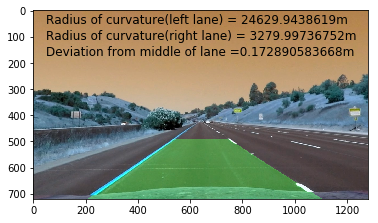

In [37]:
def Curvature_position_computation(image, warped,left_fit, right_fit, Minv):
    '''
    In this function we compute radius of curvature and position of vehicle with respect to center of lane.
    Assuming that camera is mounted in the center and if the vehicle is in center of the lane, 
    it would be exaclty in the middle of picture.
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    #print(pts_left)
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #print(pts_right)
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_raw.shape[1], image_raw.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    
    pix_center_offset = abs(warped.shape[1]/2 - (left_fitx[-1]+right_fitx[-1])/2)*3.7/700
    print(pix_center_offset)
    
    plt.text(50, 50, "Radius of curvature(left lane) = " + str(left_curverad)+'m', fontsize=12)
    plt.text(50, 110, "Radius of curvature(right lane) = " + str(right_curverad)+'m', fontsize=12)
    plt.text(50, 170, "Deviation from middle of lane =" + str(pix_center_offset)+'m', fontsize=12)
    plt.imshow(result)
    
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad, pix_center_offset, result

left_curverad, right_curverad, offset, result = Curvature_position_computation(image_undistort, warped, left_fit, right_fit, Minv)

## Pipeling of lane detection for all test images 

../test_images/test4.jpg
360.0
7332.90543759 m 810.7454552 m
0.137422150743
../test_images/test1.jpg
360.0
1184.60728714 m 1406.46270995 m
0.0625215240876
../test_images/test2.jpg
360.0
2407.75627501 m 4491.18889588 m
0.270735948715
../test_images/straight_lines2.jpg
360.0
1989.08273446 m 7922.92625111 m
0.126513274568
../test_images/test3.jpg
360.0
3385.01237918 m 6689.07822772 m
0.0270565333213
../test_images/straight_lines1.jpg
360.0
10954.2109539 m 3575.64047298 m
0.176161016076
../test_images/test6.jpg
360.0
2483.3572394 m 1206.29817038 m
0.158835034228
../test_images/test5.jpg
360.0
2028.69669371 m 519.037948359 m
0.145977967844


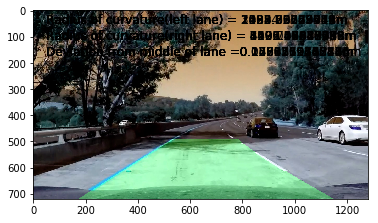

In [25]:
import os
#os.listdir("test_images/")
#image_raw = cv2.imread('../test_images/test5.jpg')
def Combined_image(image):
    
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(10, 150))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 250))

    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_thresh_min = 90
    s_thresh_max = 200
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    
    h_channel = hls[:,:,0]
    thresh = (10, 100)
    binary = np.zeros_like(h_channel)
    binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1


    #Among all 
    combined = np.zeros_like(s_binary)
    combined[((gradx == 1) & (mag_binary == 1)) | ((s_binary == 1) & (binary == 1))] = 1 
    #combined[((mag_binary == 1)) | ((s_binary == 1) & (binary == 1))] = 1 


    #Additional masking to remove the edges introduced due to initial masking. 
    vertices = np.array([[(120,image_raw.shape[0]-10),(575, 405), (700, 405), (1220,image_raw.shape[0]-10)]], dtype=np.int32)
    image_new = region_of_interest(combined, vertices)

    
    return image_new


def lane_processing(image_raw, mtx, dist, M, Minv):
    image = cv2.undistort(image_raw, mtx, dist, None, mtx)
    

    #vertices = np.array([[(50,image_raw.shape[0]),(575, 450), (750, 450), (1200,image_raw.shape[0])]], dtype=np.int32)
    vertices = np.array([[(100,image_raw.shape[0]),(575, 400), (700, 400), (1270,image_raw.shape[0])]], dtype=np.int32)
    masked_region_image = region_of_interest(image, vertices)
    
    combined = Combined_image(masked_region_image)
    
    img_size = (combined.shape[1], combined.shape[0])
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    left_fit, right_fit = polyfit(warped, False)

    left_curverad, right_curverad, offset, result = Curvature_position_computation(image_raw, warped, left_fit, right_fit, Minv)
    
    cv2.putText(result, 'radius of curvature of left lane {:.2f}m '.format(left_curverad), (100,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'radius of curvature of right lane {:.2f}m '.format(right_curverad), (100,140),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Offset {:.2f}(m)'.format(offset), (120,190),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result

def lane_video(image_raw):
    
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)
    
    image = cv2.undistort(image_raw, mtx, dist, None, mtx)
    

    #vertices = np.array([[(50,image_raw.shape[0]),(575, 450), (750, 450), (1200,image_raw.shape[0])]], dtype=np.int32)
    vertices = np.array([[(100,image_raw.shape[0]),(575, 400), (700, 400), (1270,image_raw.shape[0])]], dtype=np.int32)
    masked_region_image = region_of_interest(image, vertices)
    
    combined = Combined_image(masked_region_image)
    
    img_size = (combined.shape[1], combined.shape[0])
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)

    left_fit, right_fit = polyfit(warped, False)

    left_curverad, right_curverad, offset, result = Curvature_position_computation(image_raw, warped, left_fit, right_fit, Minv)
    
    cv2.putText(result, 'radius of curvature of left lane{:.2f}m '.format(left_curverad), (100,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result, 'radius of curvature of right lane{:.2f}m '.format(right_curverad), (100,140),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Offset {:.2f}(m)'.format(offset), (120,190),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
    return result
    

images = os.listdir("../test_images/")

#for img in images:
#    if ('processed' not in img)  and ('.ipynb' not in img):
#        print(img)
#image = cv2.imread('../test_images/test4.jpg')
#lane_detect_image = lane_processing(image, mtx, dist, M, Minv)
#plt.imshow(lane_detect_image)


for img in images:
    if ('processed' not in img) and ('.ipynb' not in img):
        print ('../test_images/' +  img)
        image = cv2.imread('../test_images/' +  img)
        #gray = cv2.COLOR_RGB2GRAY(image)
        #image = mpimg.imread('test_images/solidYellowCurve2.jpg')
        lane_detect_image = lane_processing(image, mtx, dist, M, Minv)
        #plt.imshow(lane_detect_image)
        mpimg.imsave('../test_images/' + 'processed_' + img, lane_detect_image)
    

In [ ]:
import imageio
imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
video_output = 'result.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(lane_video) 
white_clip.write_videofile(video_output, audio=False)